## Stage 2: Manual Classifier
The idea is to start with an "absolute" mapping of the chords - write some sort of script to see how close we can get to identification without machine learning

then, based on the results, we can see how we can extend it, some examples below:
- using the frequency plot or spectogram as the input to the cnn
- creating an RNN to detect chord patterns
- or some sort of system to detect the key or tonal centre of a piece

In [50]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm


In [3]:
TONE_A = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [10]:
# credit to: https://www.kaggle.com/code/slawagrechaniy/laba5?scriptVersionId=151548405&cellId=5
def plot_freq_file(fileName,FREQ_FROM = TONE_A*2**-2,FREQ_TO = TONE_A*2**4):
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) 
    data = minmax_scale(data,(-1.,1.))
 
    freq_image = fft.rfft(data,norm='forward') 
    freq_scale = fft.rfftfreq(len(data),1./rate)
    
    f_idx = np.where((freq_scale>FREQ_FROM)&(freq_scale<FREQ_TO)) 
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xscale('log',base=2.) # log scale base 2 of freq-> tone change in one octave is freq multiplication by 2 
    plt.plot(freq_scale[f_idx],np.abs(freq_image[f_idx]))
    plt.title('sound signal freq image')
    plt.xlabel('freq, [Hz]')
    plt.xticks((110,220,440,880,1760,3520),('110','220','440','880','1760','3520'))
    plt.ylabel('mode magnitude')

In [7]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


Eb
dim
Ab
maj
Bb
min


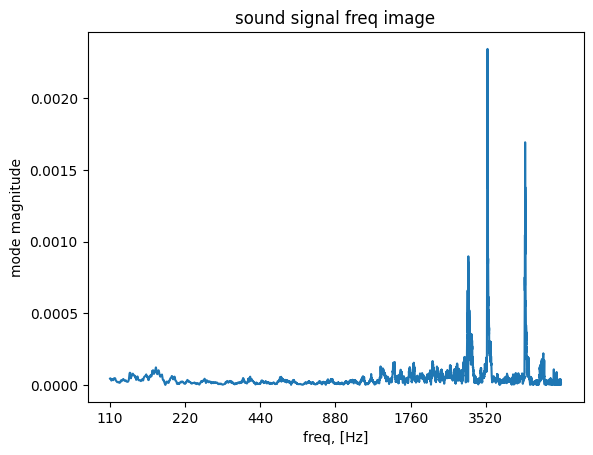

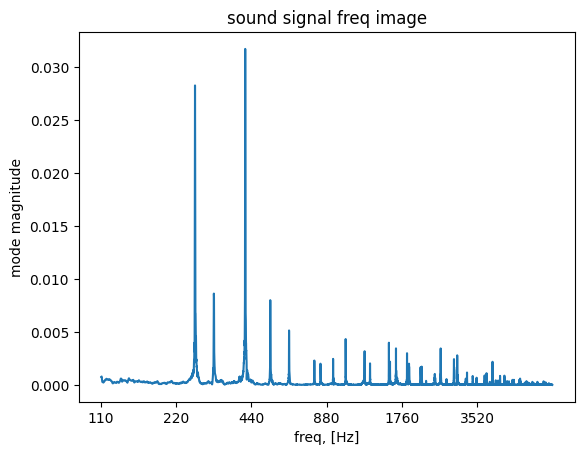

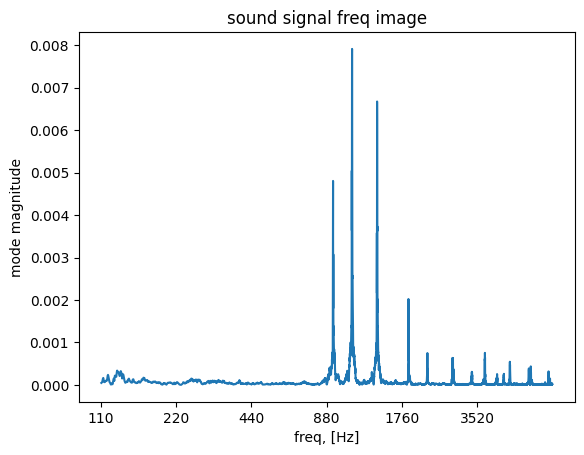

In [15]:
# run plot_freq_file on a few of the files in /data/train_set.csv:
# the file path of the files is in the "File Path Column"
print(train_set['Root Note'].iloc[0])
print(train_set['Quality'].iloc[0])
plot_freq_file(train_set['File Path'].iloc[0])
print(train_set['Root Note'].iloc[2])
print(train_set['Quality'].iloc[2])
plot_freq_file(train_set['File Path'].iloc[2])
print(train_set['Root Note'].iloc[1])
print(train_set['Quality'].iloc[1])
plot_freq_file(train_set['File Path'].iloc[1])


In [4]:
def freq_to_rnote(freq):
    r = 12.0*np.log2(freq/TONE_A)
    return r

def rnote_to_freq(r):
    f = TONE_A*2**(r/12)
    return f

def get_note_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.2):
    """ rnote - name or number of note,fft_image - fourier image of signal,
    fft_freq - frequencies in fft_image,rnote_epsilon - halfwide of window to inspect
    return maximum volume(magnitude) of signal in freq window for rnote """
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    try:
        f0 = rnote_to_freq(rnote-rnote_epsilon)
        f1 = rnote_to_freq(rnote+rnote_epsilon)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except Exception:
        return 0.
    
    return maxVol

def get_notes_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.5,oct_range_from=-4.,oct_range_to=8.):
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    rnotes = np.arange(rnote+12.*oct_range_from,rnote+12.*oct_range_to,12.0)
    vol = []
    for rn in rnotes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    return np.max(vol)

def plot_notes(fileName):
    """convert the fft image from file to notes notations and plot on"""
    #print(fileName)
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.)) 
    fft_image = np.abs(fft.rfft(data,norm='forward')) 
    fft_freq = fft.rfftfreq(len(data),1./rate)
    vol_matrix = np.ndarray(shape=(12),dtype=np.float32)
    for rnote in range(12):
        vol_matrix[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
        
    plt.bar(NOTES, vol_matrix)
    plt.show()

Eb
dim


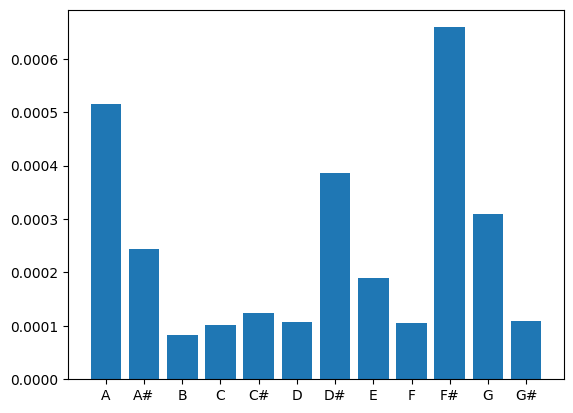

None
Ab
maj


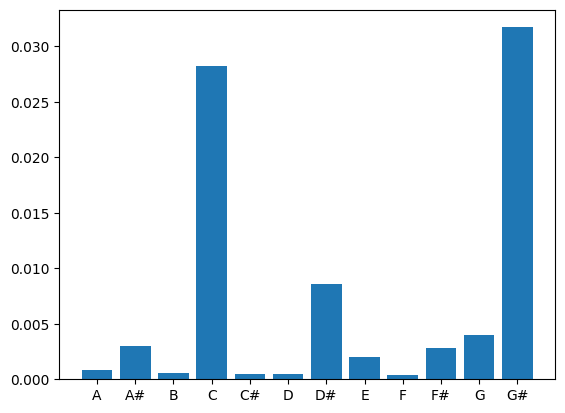

None
Bb
min


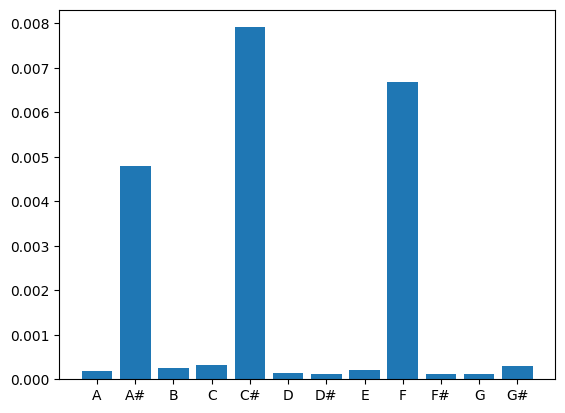

None


In [20]:
print(train_set['Root Note'].iloc[0])
print(train_set['Quality'].iloc[0])
print(plot_notes(train_set['File Path'].iloc[0]))
print(train_set['Root Note'].iloc[2])
print(train_set['Quality'].iloc[2])
print(plot_notes(train_set['File Path'].iloc[2]))
print(train_set['Root Note'].iloc[1])
print(train_set['Quality'].iloc[1])
print(plot_notes(train_set['File Path'].iloc[1]))


In [25]:
def chord_quality(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    major_vol = []
    minor_vol = []
    diminished_vol = []
    augmented_vol = []

    for rnote in range(12):
        vol = get_notes_volume(rnote,fft_image,fft_freq)
        v3 = get_notes_volume((rnote+3)%12,fft_image,fft_freq)
        v4 = get_notes_volume((rnote+4)%12,fft_image,fft_freq)
        v6 = get_notes_volume((rnote+6)%12,fft_image,fft_freq)
        v7 = get_notes_volume((rnote+7)%12,fft_image,fft_freq)
        v8 = get_notes_volume((rnote+8)%12,fft_image,fft_freq)

        major_vol.append(vol + v4 + v7)
        minor_vol.append(vol + v3 + v7)
        diminished_vol.append(vol + v3 + v6)
        augmented_vol.append(vol + v4 + v8)
    
    major_max = [max(major_vol), NOTES[major_vol.index(max(major_vol))]]
    minor_max = [max(minor_vol), NOTES[minor_vol.index(max(minor_vol))]] 
    diminished_max = [max(diminished_vol), NOTES[diminished_vol.index(max(diminished_vol))]] 
    augmented_max = [max(augmented_vol), NOTES[augmented_vol.index(max(augmented_vol))]] 

    if max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == major_max[0]:
        return 'maj', major_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == minor_max[0]:
        return 'min', minor_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == diminished_max[0]:
        return 'dim', diminished_max[1]
    else:
        return 'aug', augmented_max[1]

In [8]:
# print a summary of the chord qualities in the train set
print(train_set['Quality'].value_counts())

Quality
aug    179
dim    178
min    178
maj    178
Name: count, dtype: int64


In [28]:
# test this function on the entire training set (by checking if chord_quality matches the Quality column)
# and report the accuracy of the function

# i just want this to be calculated, not saved to the dataframe
major_correct = 0
major_incorrect = 0
minor_correct = 0
minor_incorrect = 0
# calculate this for diminished and augmented chords as well
diminished_correct = 0
diminished_incorrect = 0
augmented_correct = 0
augmented_incorrect = 0

root_note_correct = 0
root_note_incorrect = 0

for i in tqdm(range(len(train_set))):
    quality, root_note = chord_quality(train_set['File Path'].iloc[i])
    if train_set['Quality'].iloc[i] == 'maj':
        if quality == 'maj':
            major_correct += 1
        else:
            major_incorrect += 1
            # print(train_set['Octave'].iloc[i])

    elif train_set['Quality'].iloc[i] == 'min':
        if quality == 'min':
            minor_correct += 1
        else:
            minor_incorrect += 1
            # print(train_set['Octave'].iloc[i])

    elif train_set['Quality'].iloc[i] == 'dim':
        if quality == 'dim':
            diminished_correct += 1
        else:
            diminished_incorrect += 1
            # print(train_set['Octave'].iloc[i])

    elif train_set['Quality'].iloc[i] == 'aug':
        if quality == 'aug':
            augmented_correct += 1
        else:
            augmented_incorrect += 1
            # print(train_set['Octave'].iloc[i])
    
    if root_note != train_set['Root Note'].iloc[i] and train_set['Quality'].iloc[i] != 'aug':
        root_note_incorrect += 1
    else:
        root_note_correct += 1

print('major correct: ', major_correct)
print('major incorrect: ', major_incorrect)
print('minor correct: ', minor_correct)
print('minor incorrect: ', minor_incorrect)
print('diminished correct: ', diminished_correct)
print('diminished incorrect: ', diminished_incorrect)
print('augmented correct: ', augmented_correct)
print('augmented incorrect: ', augmented_incorrect)
print('root note correct: ', root_note_correct)
print('root note incorrect: ', root_note_incorrect)

print('major accuracy: ', major_correct/(major_correct+major_incorrect))
print('minor accuracy: ', minor_correct/(minor_correct+minor_incorrect))
print('diminished accuracy: ', diminished_correct/(diminished_correct+diminished_incorrect))
print('augmented accuracy: ', augmented_correct/(augmented_correct+augmented_incorrect))
print('root note accuracy: ', root_note_correct/(root_note_correct+root_note_incorrect))
# show overall accuracy
print('overall chord quality accuracy: ', (major_correct+minor_correct+diminished_correct+augmented_correct)/(major_correct+major_incorrect+minor_correct+minor_incorrect+diminished_correct+diminished_incorrect+augmented_correct+augmented_incorrect))


100%|██████████| 713/713 [00:09<00:00, 72.75it/s]

major correct:  174
major incorrect:  4
minor correct:  172
minor incorrect:  6
diminished correct:  173
diminished incorrect:  5
augmented correct:  173
augmented incorrect:  6
root note correct:  573
root note incorrect:  140
major accuracy:  0.9775280898876404
minor accuracy:  0.9662921348314607
diminished accuracy:  0.9719101123595506
augmented accuracy:  0.9664804469273743
root note accuracy:  0.8036465638148668
overall chord quality accuracy:  0.97054698457223


In [29]:
def preprocess(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    major_vol = []
    minor_vol = []
    diminished_vol = []
    augmented_vol = []

    note_vols = np.zeros(12)

    for rnote in range(12):
        note_vols[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
    
    # get the indexes of the top 3 notes
    top_notes = note_vols.argsort()[-3:][::-1]
    
    # get the differences between the top 3 notes
    diffs = []
    for i in range(len(top_notes)-1):
        diffs.append(top_notes[i] - top_notes[i+1])
    
    diffs.append(top_notes[0] - top_notes[-1])

    return diffs, note_vols
 

In [60]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [61]:
print(preprocess(train_set['File Path'].iloc[0]))
# replace all paths in train_set and test_set that have a # in it to replace the # with s
train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

([9, -1, 8], array([5.14683663e-04, 4.98163980e-04, 8.30797944e-05, 1.02320169e-04,
       1.23592006e-04, 1.07863976e-04, 3.86379659e-04, 1.89827930e-04,
       1.05026404e-04, 6.59153040e-04, 3.10034287e-04, 1.09101835e-04]))


In [62]:
# add the diffs and note_vols columns to the train set, where each diff note_vol is a different column
for j in range(3):
    train_set['diff' + str(j)] = None

for k in range(12):
    train_set['note_vol' + str(k)] = None

diffs = []
note_vols = []
for i in tqdm(range(len(train_set))):
    diff, note_vol = preprocess(train_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            train_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            train_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)


  0%|          | 0/713 [00:00<?, ?it/s]/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2012/677521670.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['diff' + str(j)].iloc[i] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2012/677521670.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['diff' + str(j)].iloc[i] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2012/677521670.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [63]:
# print the head of the train_set to make sure the columns were added correctly
print(train_set.head())

                               File Path Root Note  Octave Quality  Inversion  \
0   data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim          1   
3   data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min          0   
20  data/chords/maj/Ab-3-maj-chord-1.wav        Ab       3     maj          1   
28  data/chords/aug/Ab-2-aug-chord-0.wav        Ab       2     aug          0   
32   data/chords/aug/G-4-aug-chord-1.wav         G       4     aug          1   

   diff0 diff1 diff2 note_vol0 note_vol1 note_vol2 note_vol3 note_vol4  \
0      9    -1     8  0.000515  0.000498  0.000083  0.000102  0.000124   
3     -4     7     3  0.000197  0.004805  0.000518  0.000394  0.007915   
20     8    -3     5  0.000794  0.002993  0.000608  0.028265  0.000975   
28     4     4     8  0.000913  0.001247  0.002298  0.020926  0.001299   
32    -8     4    -4  0.000572  0.001208  0.008392  0.000506  0.000611   

   note_vol5 note_vol6 note_vol7 note_vol8 note_vol9 note_vol10 note

In [64]:
for j in range(3):
    test_set['diff' + str(j)] = None

for k in range(12):
    test_set['note_vol' + str(k)] = None


for i in tqdm(range(len(test_set))):
    diff, note_vol = preprocess(test_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            test_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            test_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)

  0%|          | 0/307 [00:00<?, ?it/s]/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2012/2104497060.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['diff' + str(j)].iloc[i] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2012/2104497060.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['diff' + str(j)].iloc[i] = diff[j]
/var/folders/x_/0gc9r1qx05nfx7tp3rdjsf340000gn/T/ipykernel_2012/2104497060.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [65]:
print(test_set.head())

                               File Path Root Note  Octave Quality  Inversion  \
10  data/chords/aug/Cs-4-aug-chord-1.wav        C#       4     aug          1   
12   data/chords/aug/A-5-aug-chord-1.wav         A       5     aug          1   
15   data/chords/min/F-4-min-chord-2.wav         F       4     min          2   
16  data/chords/aug/Ab-7-aug-chord-0.wav        Ab       7     aug          0   
18   data/chords/dim/F-7-dim-chord-0.wav         F       7     dim          0   

   diff0 diff1 diff2 note_vol0 note_vol1 note_vol2 note_vol3 note_vol4  \
10    -8     4    -4  0.021142   0.00095  0.000786  0.001522  0.007849   
12    -4     8     4   0.00494  0.000153  0.000228  0.000305  0.006822   
15    -8     3    -5   0.00202  0.000759  0.000409  0.006797  0.000349   
16     4     4     8  0.000152  0.000205  0.000121  0.000386  0.000211   
18    -3     9     6  0.000223  0.000229   0.00034  0.000218  0.000075   

   note_vol5 note_vol6 note_vol7 note_vol8 note_vol9 note_vol10 note

In [23]:
# remove diff2 from the train_set
train_set = train_set.drop(columns=['diff2'])

In [66]:
# train a KNN to predict the quality based on the diff and note_vol columns
from sklearn.neighbors import KNeighborsClassifier

# create the KNN model
knn = KNeighborsClassifier(n_neighbors=3)

# create the X and y arrays
X = train_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion'])
y = train_set['Quality']

# fit the model
knn.fit(X, y)

# predict the quality of the test_set
predictions = knn.predict(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']))

# print the accuracy of the model
print(knn.score(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']), test_set['Quality']))


0.8990228013029316


we have every note and the amount of that note
to get it manually we took every chord and found how much of each chord is in that note

what would be useful would be to use something like the intervals as a feature

i would imagine using the amount of each note would be useful but this has not worked in the past

what if we started with something that we know would work and then worked backwards from there

In [70]:
# try multi class logistic regression
from sklearn.linear_model import LogisticRegression

# create the logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model
logreg.fit(X, y)

# predict the quality of the test_set
predictions = logreg.predict(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']))

# print the accuracy of the model
print(logreg.score(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']), test_set['Quality']))


0.23778501628664495


In [46]:
# try a random forest
from sklearn.ensemble import RandomForestClassifier

# create the random forest model
rf = RandomForestClassifier(n_estimators=100)

# fit the model
rf.fit(X, y)

# predict the quality of the test_set
predictions = rf.predict(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']))

# print the accuracy of the model
print(rf.score(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']), test_set['Quality']))


0.8338762214983714
